In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import os
import shutil

import numpy as np 
import pandas as pd

import pydicom as dicom
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
train_dir = Path('E:\data\RSNA2024')

class CFG:
    random_seed = 42
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'



In [4]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)

coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

coords_df.shape, files_df.shape, train_df.shape, train_desc_df.shape

((48692, 17), (147218, 17), (1975, 26), (6294, 3))

In [5]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc
34816,3086193490,1572154517,6,SCS,L2L3,175.430283,102.135076,3086193490_1572154517,3086193490_1572154517_6,SCSL2L3,Sagittal T2/STIR,320,320,E:\data\RSNA2024\pngs_256\3086193490_157215451...,FFS,0.548220,0.319172
28303,2531147217,2816277994,10,RSS,L3L4,305.977131,354.594595,2531147217_2816277994,2531147217_2816277994_10,RSSL3L4,Axial T2,640,640,E:\data\RSNA2024\pngs_256\2531147217_281627799...,HFS,0.478089,0.554054


### Filter bad labels

In [178]:
bad_labels = [3819260179, 2444340715] + coords_df[coords_df['x'] < 10].study_id.tolist()

print(bad_labels), len(bad_labels)

[3819260179, 2444340715, 38281420, 286903519, 665627263, 1438760543, 1510451897, 1820866003, 1880970480, 1901348744, 2151467507, 2151509334, 2316015842, 2444340715, 2905025904]


(None, 15)

In [176]:
clean_coords_df = coords_df[~coords_df['study_id'].isin(bad_labels)]

coords_df.shape, clean_coords_df.shape

((48692, 17), (48350, 17))

### Condition positions on frame

In [182]:
clean_coords_df.groupby('series_description').agg({'x_perc': ['min', 'max'],'y_perc': ['min', 'max']})

x_perc              y_perc          
                         min       max       min       max
series_description                                        
Axial T2            0.284956  0.663196  0.309262  0.807810
Sagittal T1         0.208464  0.768467  0.107511  0.882793
Sagittal T2/STIR    0.106874  0.768142  0.141429  0.876847

In [183]:
# clean_coords_df.groupby('series_description').agg({'y_perc': ['min', 'max']})

In [8]:
coords_df.iloc[coords_df['y_perc'].argmin()]

study_id                                                     1820866003
series_id                                                     131094096
instance                                                              7
condition                                                           SCS
level                                                              L2L3
x                                                                   5.0
y                                                              2.063098
ss_id                                              1820866003_131094096
instance_id                                      1820866003_131094096_7
cl                                                              SCSL2L3
series_description                                     Sagittal T2/STIR
rows                                                                512
columns                                                             512
filename              E:\data\RSNA2024\pngs_256\1820866003_13109

### Plot conditions

In [9]:
row = coords_df.iloc[coords_df['y_perc'].argmin()]

row['level']

'L2L3'

In [50]:
coords_df.groupby(['study_id', 'condition']).instance_id.count().mean()

4.9353334684776

In [37]:
def plot(row, source=CFG.IMAGES_DIR):
    # filename = row['filename']

    filename = source / str(row['study_id']) / str(row['series_id']) / f'{row["instance"]}.dcm'

    conds = coords_df[coords_df['ss_id'] == row['ss_id']]

    print(row['study_id'])
    print(conds.x.to_list())
    print(conds.cl.to_list())
    print(conds.y.to_list())
    
    ds = dicom.dcmread(filename)
    img = ds.pixel_array

    # img = (img - img.min()) / (img.max() - img.min())

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    plt.imshow(img, cmap="gray")
    
    # plt.scatter(row['x'], row['y'], marker="x", color="red", s=200)

    plt.title(row['series_description'] + f' - {row["instance"]}')

    plt.scatter(conds.x.to_list(), conds.y.to_list(), marker="x", color="red", s=200)
    
    plt.show()

In [43]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc
33410,2947917201,402273571,7,SCS,L3L4,161.515152,170.757576,2947917201_402273571,2947917201_402273571_7,SCSL3L4,Sagittal T2/STIR,320,320,E:\data\RSNA2024\pngs_256\2947917201_402273571...,HFS,0.504735,0.533617
18656,1671676307,77368487,7,RNFN,L1L2,282.921606,130.202677,1671676307_77368487,1671676307_77368487_7,RNFNL1L2,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\1671676307_77368487_...,FFS,0.552581,0.254302


In [167]:
def plot_conditions(study_id, source=CFG.IMAGES_DIR):
    df = coords_df[coords_df['study_id'] == study_id].sort_values(by='series_description', ascending=False)

    ss_ids = df.instance_id.unique()
    imgs = dict(zip(ss_ids, [{'points':[], 'labels':[]} for i in ss_ids]))

    for i in df.instance_id.unique():
        sel = df[df['instance_id'] == i]

        row = sel.iloc[0]
        imgs[i]['filename'] = source / str(row['study_id']) / str(row['series_id']) / f'{row["instance"]}.dcm'
        imgs[i]['title'] = ('-').join([row.series_description] + sel.condition.unique().tolist())

        for index, row in sel.iterrows():
            imgs[i]['points'].append((row.x, row.y, row.condition))

    rows = len(imgs.keys()) // 4 + 1
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    fig.suptitle(study_id)

    axs = axs.flat

    for i, (key, value) in enumerate(imgs.items()):
        ax = axs[i]

        ax.margins(0, 0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.title.set_text(value['title'])
        
        ds = dicom.dcmread(value['filename'])
        img = ds.pixel_array

        # img = (img - img.min()) / (img.max() - img.min())

        if ds.PhotometricInterpretation == "MONOCHROME1":
            img = 1 - img

        ax.imshow(img, cmap="gray")

        for p in value['points']:
            ax.scatter(p[0], p[1], label=p[2], marker="x", color="red", s=200)
    
    plt.show()

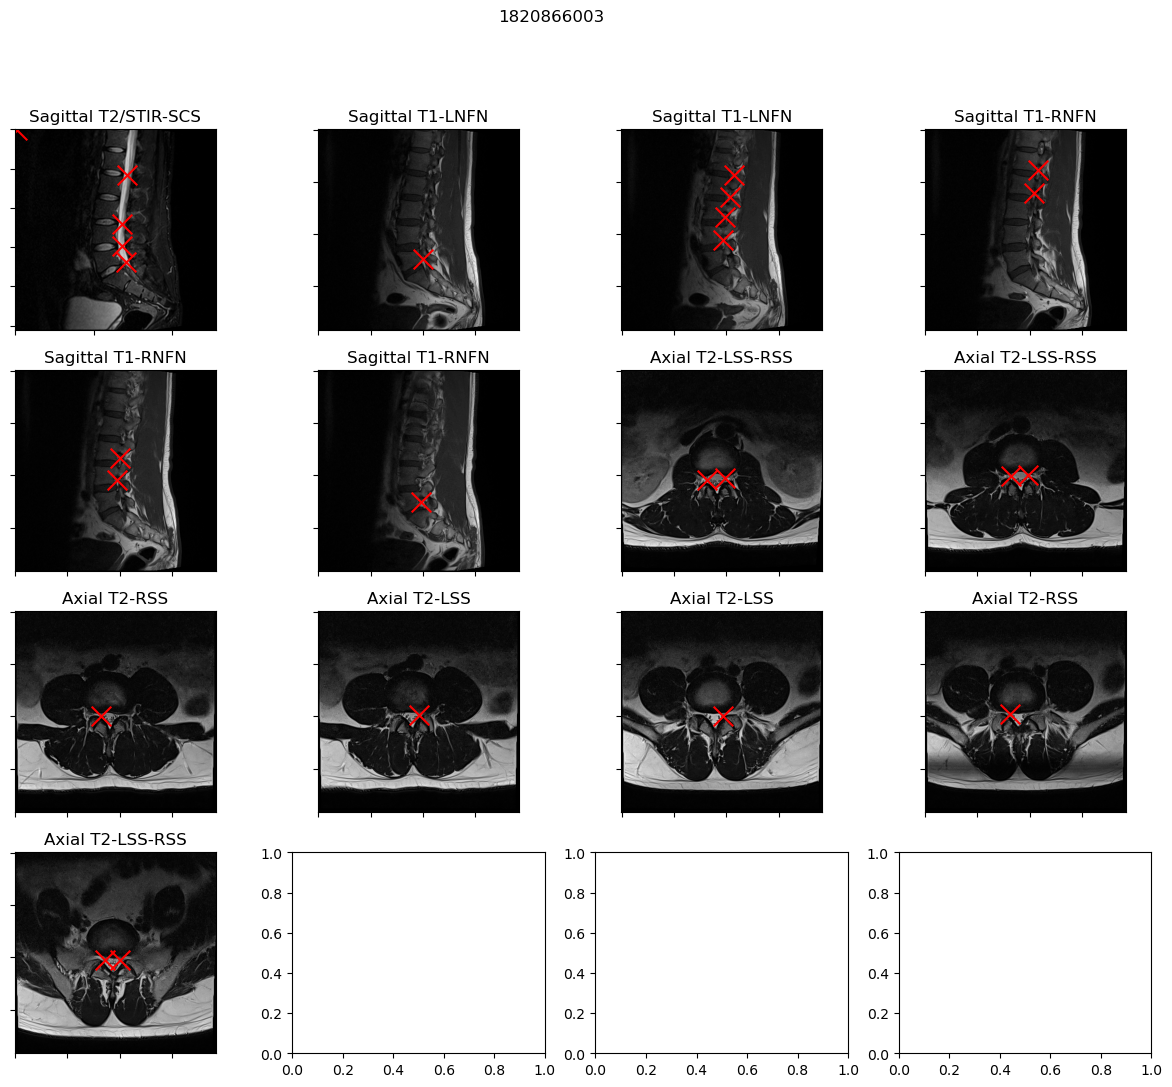

In [168]:
plot_conditions(1820866003)

#### Plot min x,y labels

3819260179


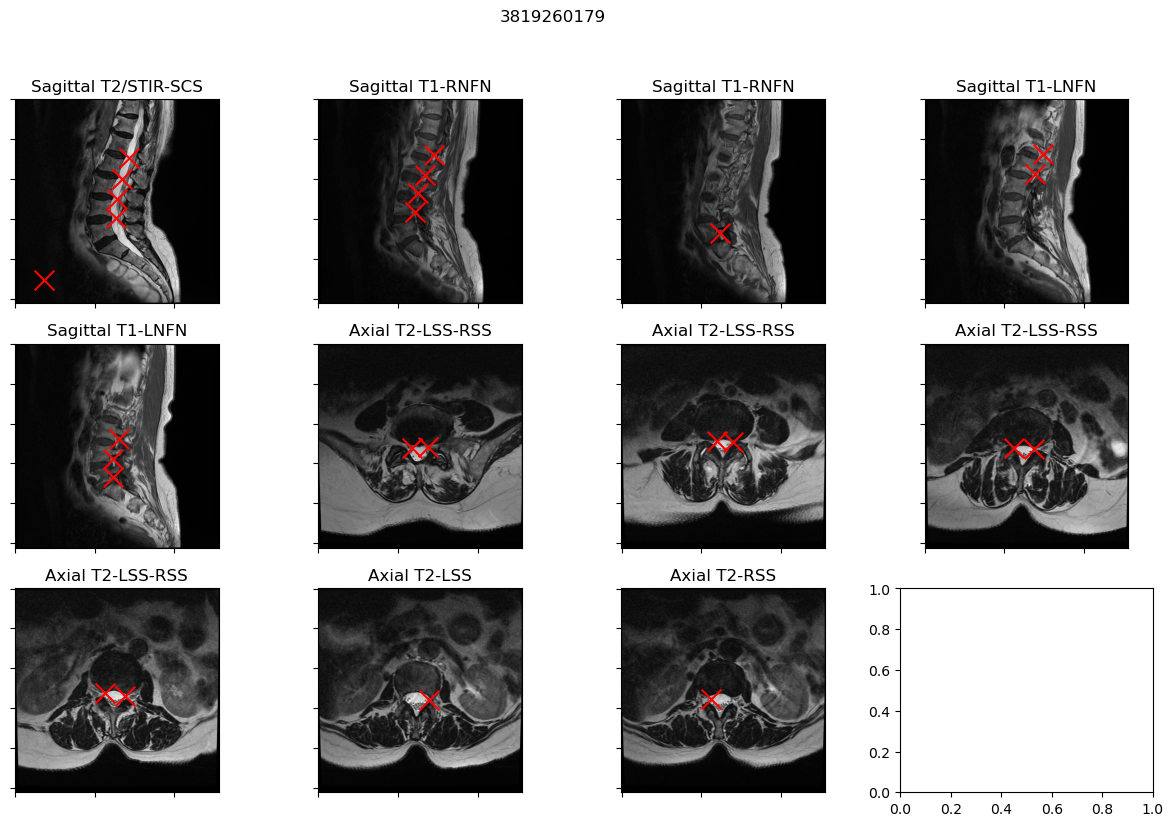

In [191]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = coords_df[coords_df['x_perc'] < 0.15].study_id.tolist()

bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

print(row.study_id)

# plot(row)
plot_conditions(row.study_id)

In [170]:
coords_df[coords_df['x'] < 10].shape, coords_df[coords_df['y'] < 10].shape

((13, 17), (13, 17))

#### Plot max x,y labels

3819260179


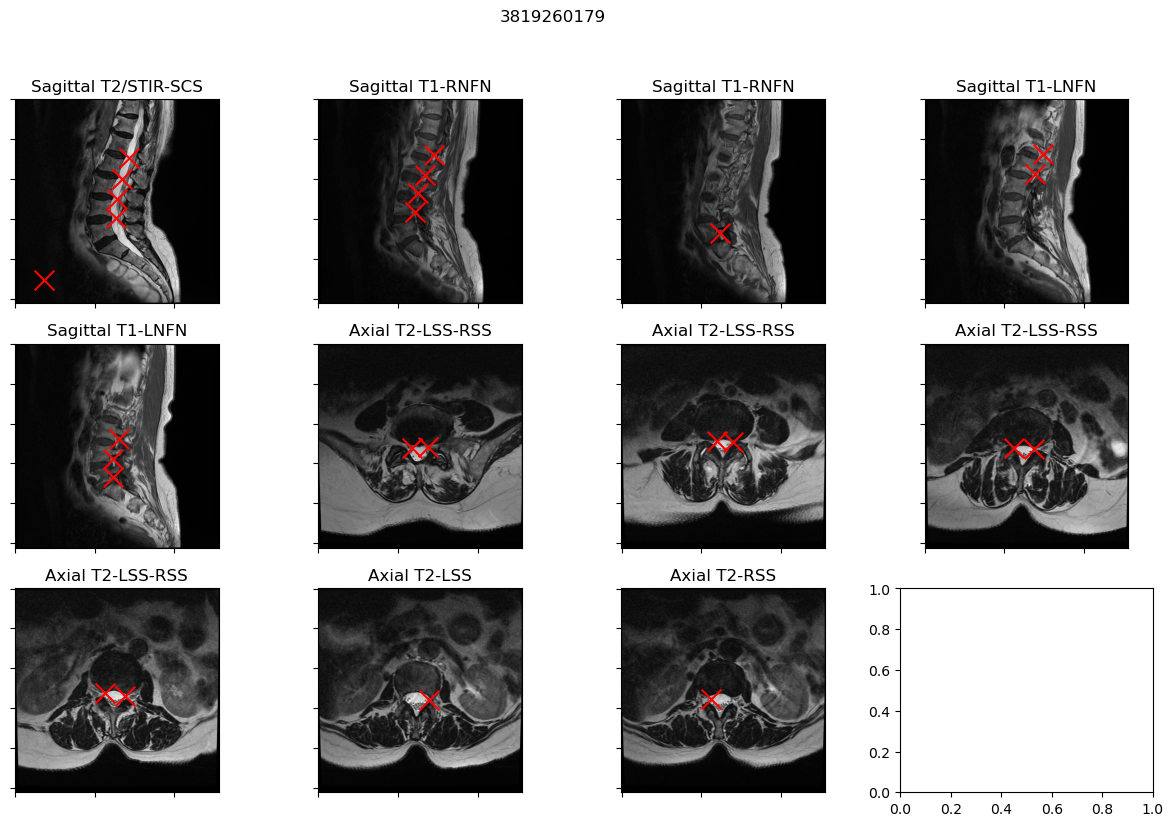

In [171]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

# bad_labels = [3819260179]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

print(row.study_id)

# plot(row)
plot_conditions(row.study_id)

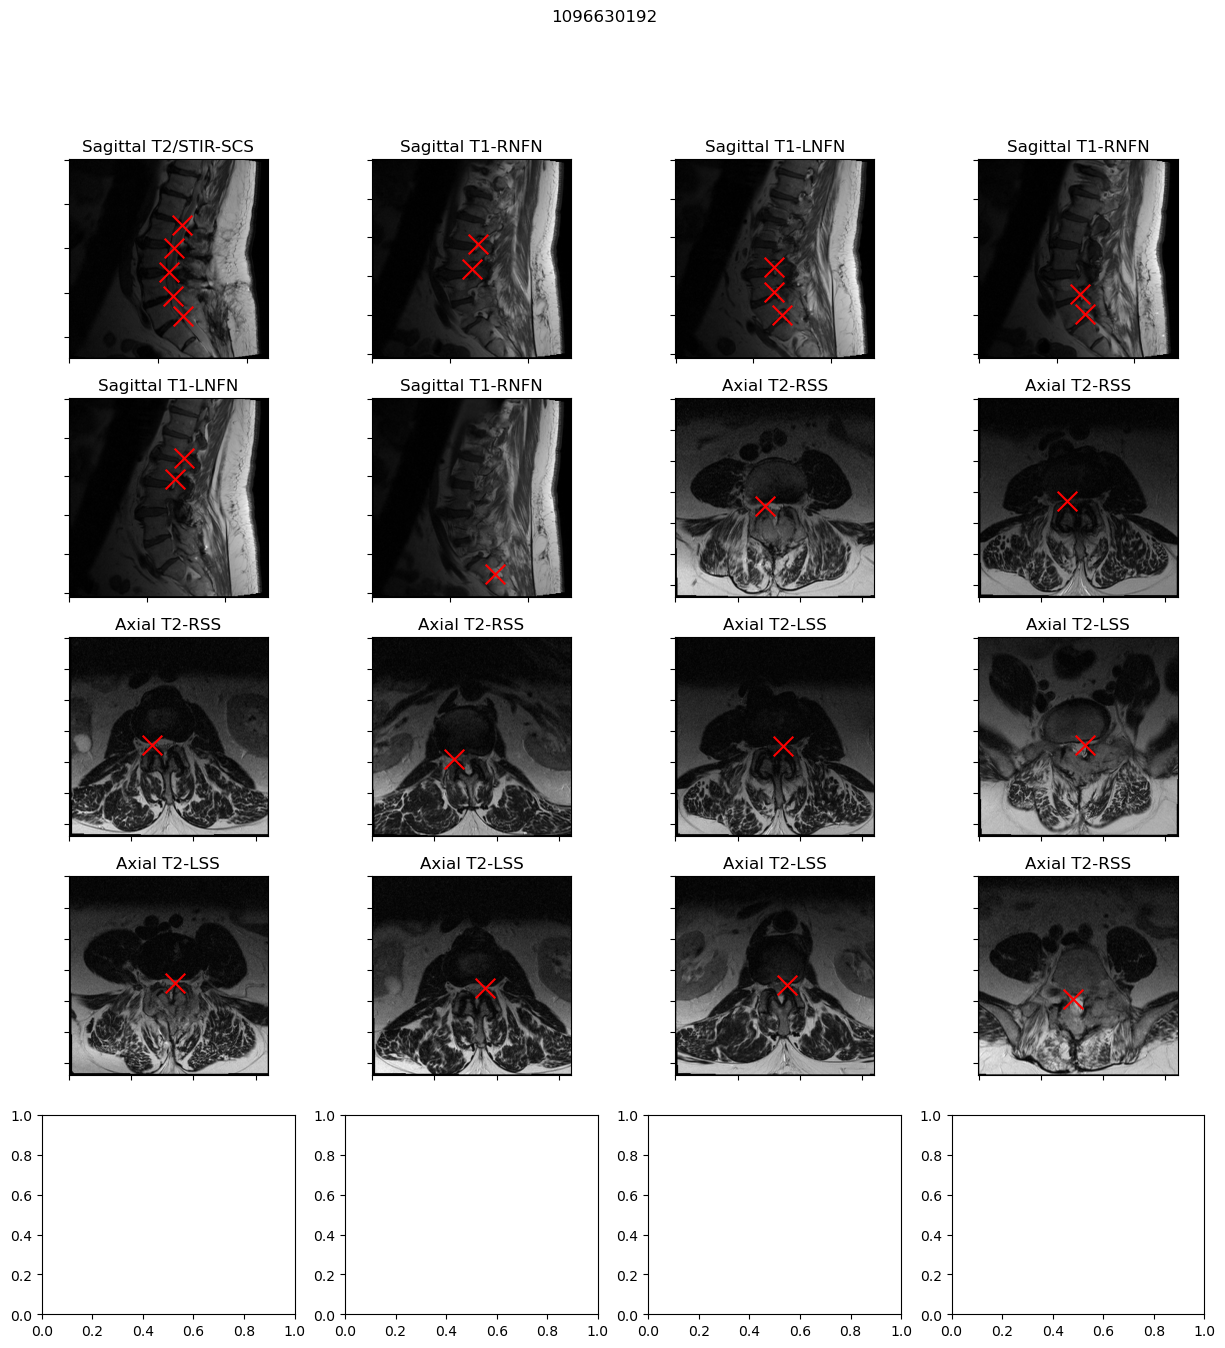

In [172]:
# bad labels
# bad_labels = [1820866003, 665627263, 2151509334, 1901348744, 286903519, 1880970480, 2151467507, 2905025904]

bad_labels = [3819260179, 2444340715]

# bad_labels = coords_df[coords_df['x'] < 10].study_id.tolist()

selection = coords_df[~coords_df['study_id'].isin(bad_labels)]
row = selection.iloc[selection['y_perc'].argmax()]

# plot(row)
plot_conditions(row.study_id)

### Right/left orientation

<Axes: >

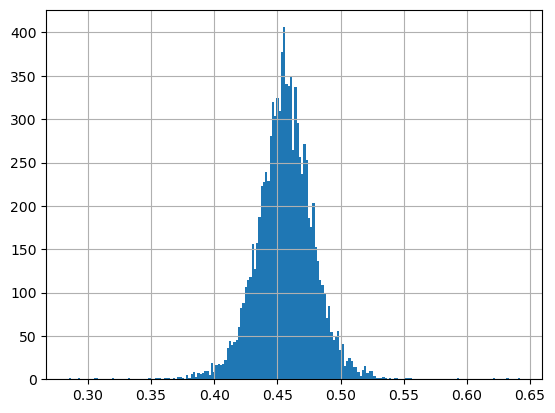

In [15]:
selection = coords_df[coords_df['condition'] == 'RSS']

selection.x_perc.hist(bins=200)

In [16]:
selection.patientposition.value_counts()

patientposition
HFS    7675
FFS    1937
Name: count, dtype: int64

In [17]:
selection[selection['x_perc'] > 0.50].patientposition.value_counts()

patientposition
HFS    196
FFS     59
Name: count, dtype: int64

In [18]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    2884
FFS     696
Name: count, dtype: int64

<Axes: >

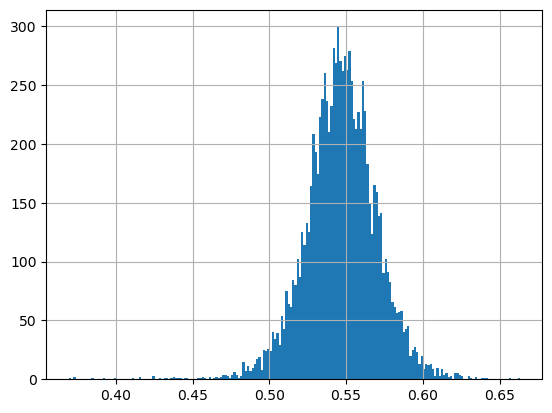

In [19]:
selection = coords_df[coords_df['condition'] == 'LSS']

selection.x_perc.hist(bins=200)

In [20]:
selection[selection['x_perc'] < 0.45].patientposition.value_counts()

patientposition
HFS    13
FFS    10
Name: count, dtype: int64

In [21]:
selection[selection['x_perc'] < 0.45].study_id.unique()

array([ 391103067,  677672203,  757619082, 1406734395, 1647904243,
       1670838975, 2399492744, 3495818564, 3945605592, 4072191052],
      dtype=int64)

### Frame positions in series

In [22]:
coords_df.sample(2)

,study_id,series_id,instance,condition,level,x,y,ss_id,instance_id,cl,series_description,rows,columns,filename,patientposition,x_perc,y_perc
34254,3030051271,2141431060,6,RNFN,L3L4,287.322353,191.247059,3030051271_2141431060,3030051271_2141431060_6,RNFNL3L4,Sagittal T1,512,512,E:\data\RSNA2024\pngs_256\3030051271_214143106...,HFS,0.561176,0.373529
34527,3057988981,623313767,43,LSS,L4L5,352.075290,308.880309,3057988981_623313767,3057988981_623313767_43,LSSL4L5,Axial T2,640,640,E:\data\RSNA2024\pngs_256\3057988981_623313767...,HFS,0.550118,0.482625
